**Author**: Lulof Pirée

**Date**: June 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Second pre-study: finding an appropriate rate-constant
for the repression of the inflammation by Gr*,
under the assumption that the repression is strong with maximal Gr*.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import stats
import math
from numbers import Number

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes, get_num_timeboxes_for_fixed_duration,
    get_max_timestamp)
import numpy as np

SAVEDIR_NAME = "tune_inflam_repress_rate_data"

NUM_REPETITIONS = 200
MAX_NUM_TRANSITIONS = float("inf")
MAX_TIME_PASSED = 0.005
# Different constants to try
REPRESSION_RATE_CONSTANTS = [0, 0.01, 1, 2.5, 5, 10]
# One token represents 0.1% of the starting amount.
INIT_TOKEN_COUNT = 1000 

# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "tune_inflam_repress_rate.ipynb" in os.listdir(os.getcwd()):
    SAVE_DIR = os.path.join(os.getcwd(), SAVEDIR_NAME)
else:
    raise RuntimeError("Wrong working directory.")

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Experiment
Initially, we set:
* $[Gr*] = [\text{Free Neutrophils}] = [\text{inflammation signals}] = 1000$,
    and 0 for all other places.
* The rate-function for recruiting neutrophils is simply given
    as $f() = [\text{Free Neutrophils}] \times [\text{inflammation signals}]$.


In [2]:
def run_tuning_experiment():
    init_markings = setup_markings()
    for rate_const in REPRESSION_RATE_CONSTANTS:
        RATE_AS_DIRNAME = rate_const_to_dirname(rate_const)
        SUBDIR_NAME = os.path.join(SAVE_DIR, RATE_AS_DIRNAME)
        rates = setup_rates(rate_const)

        log_filename = os.path.join(SUBDIR_NAME, "logs.json")
        if not os.path.exists(log_filename):
            run_experiment(rates, init_markings, SUBDIR_NAME, NUM_REPETITIONS, 
                        max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)
        else:
            print("Experiment data already present, skipping experiment.")
    
def rate_const_to_dirname(rate_const: int | float) -> str:
        # Convert the rate to scientific notation, without a '.' or a '+'.
        # Then it is safe to use as a directory name.
        return f"rate_{rate_const:.0e}".replace("+", "")

def setup_markings() -> dict[str, tuple[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)
    init_markings["gr_pdn"] = (INIT_TOKEN_COUNT,)
    return init_markings


def setup_rates(repress_rate_const: float | int) -> dict[str, str]:
    rates = {name : "0" for name in TRANS}
    rates["recruit_neutrophil"] = f"{VARS['infl_sig']} * {VARS['neutrophil_free']}"
    rates["repress_infl"] = f"{repress_rate_const} * {VARS['infl_sig']} * {VARS['gr_pdn']}"
    return rates



run_tuning_experiment()

Experiment data already present, skipping experiment.
Experiment data already present, skipping experiment.
Experiment data already present, skipping experiment.
Experiment data already present, skipping experiment.
Experiment data already present, skipping experiment.
Experiment data already present, skipping experiment.


## Unrepressed baseline
Find $t$, the timestamp after which half of the neutrophils
has been recruited, when no repression is applied ($[Gr*]=0$).

[Text(0, 0.5, 'Neutrophil concentration'),
 Text(0.5, 1.0, 'Neutrophil recruitment without repression')]

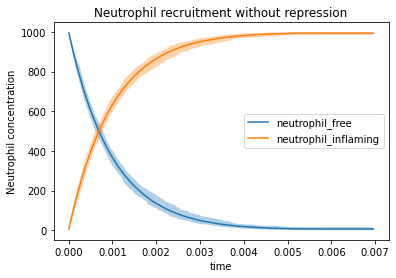

In [3]:
baseline_log = load_log(os.path.join(SAVEDIR_NAME, rate_const_to_dirname(0),
    "logs.json"))

BASELINE_NUM_TIMEBOXES = 500
DESIRED_TIMEBOX_DURATION = MAX_TIME_PASSED/BASELINE_NUM_TIMEBOXES
num_timeboxes = get_num_timeboxes_for_fixed_duration(baseline_log, 
                                        DESIRED_TIMEBOX_DURATION)
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
ax = plot_results(baseline_log, x_var, y_vars, 
             num_timeboxes, interval_type="min_max")
ax.set(ylabel="Neutrophil concentration",
    title="Neutrophil recruitment without repression")

In [4]:
baseline_aggregated, timebox_duration = aggregate_dataset_in_timeboxes(
    baseline_log, "time", ["neutrophil_inflaming"], num_timeboxes)
# Average out over independent runs
baseline_aggregated = np.mean(baseline_aggregated["neutrophil_inflaming"], axis=0)

In [5]:
curr_timebox_idx = 0
target_concentration = INIT_TOKEN_COUNT//2
while baseline_aggregated[curr_timebox_idx] < target_concentration:
    curr_timebox_idx += 1

TARGET_TIMESTAMP = curr_timebox_idx*timebox_duration
print(f"Half of neutrophils recruited after "
      f"{curr_timebox_idx*timebox_duration:.10f} time.")

Half of neutrophils recruited after 0.0006903601 time.


## Main experiment
Plot the amount of neutrophils after $t$ time (see value above)
for different repression rates.
The least rate that achieves good repression would
probably the best choice for the model.

Rate = 0e+00
	Max time: 0.00574
	Num timeboxes: 696
	Timebox duration: 0.00001
	Target timebox index: 69

Rate = 1e-02
	Max time: 0.00502
	Num timeboxes: 538
	Timebox duration: 0.00001
	Target timebox index: 69

Rate = 1e+00
	Max time: 0.00507
	Num timeboxes: 624
	Timebox duration: 0.00001
	Target timebox index: 69

Rate = 2e+00
	Max time: 0.00277
	Num timeboxes: 476
	Timebox duration: 0.00001
	Target timebox index: 69

Rate = 5e+00
	Max time: 0.00127
	Num timeboxes: 260
	Timebox duration: 0.00001
	Target timebox index: 69

Rate = 1e+01
	Max time: 0.00059
	Num timeboxes: 124
	Timebox duration: 0.00001
	Target timebox index: 68



/tmp/ipykernel_5566/2549438228.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


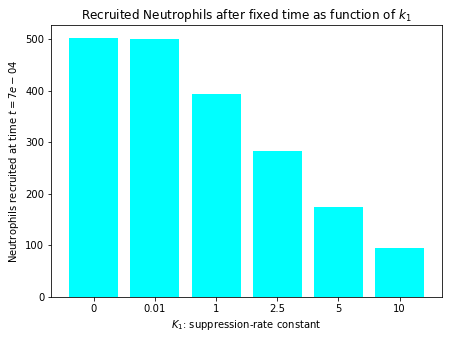

In [6]:
fig, ax = plt.subplots(figsize=(7,5))


bar_heights = []
# List of observed means in the target timebox, one value for for each run.
# One such list for each rate-constant-value.
# Used for running a t-test.
measurements_per_rate : dict[float, list[float]] = {}

for rate_const in REPRESSION_RATE_CONSTANTS:
        log_dirname = rate_const_to_dirname(rate_const)
        log_filename = os.path.join(SAVE_DIR, log_dirname, "logs.json")
        log = load_log(log_filename)
        print(f"Rate = {rate_const:.0e}\n\tMax time: {max(log[0]['time']):0.5f}")
        num_timeboxes = get_num_timeboxes_for_fixed_duration(log, DESIRED_TIMEBOX_DURATION)
        print(f"\tNum timeboxes: {num_timeboxes}")
        timeboxed_neutrophils, timebox_duration = aggregate_dataset_in_timeboxes(
                log, "time", ["neutrophil_inflaming"], num_timeboxes)
        print(f"\tTimebox duration: {timebox_duration:.5f}")
        # Average out over independent runs
        av_neutrophils_per_timebox = np.mean(
                timeboxed_neutrophils["neutrophil_inflaming"], axis=0)

        target_timebox = math.floor(TARGET_TIMESTAMP/timebox_duration)
        print(f"\tTarget timebox index: {target_timebox}")
        bar_heights.append(av_neutrophils_per_timebox[target_timebox])
        print("")

        measurements_per_rate[rate_const] = list(
                means_per_timebox[target_timebox]
                for means_per_timebox in
                timeboxed_neutrophils["neutrophil_inflaming"])

ax.bar([1+x for x in range(len(REPRESSION_RATE_CONSTANTS))], bar_heights,
        color="cyan")
ax.set(
        xticklabels = [""]+REPRESSION_RATE_CONSTANTS,
        xlabel="$K_1$: suppression-rate constant",
        ylabel=f"Neutrophils recruited at time $t={TARGET_TIMESTAMP:.0e}$",
        title="Recruited Neutrophils after fixed time as function of $k_1$"
);
fig.savefig(os.path.join(SAVEDIR_NAME, "repression_rate_effects.pdf"))

## Conclusion

A rate constant of 2.5 does not reduce the number of recruited neutrophils by half.
A constant of 5 reduces the neutrophils at time $t$ by approximately 60-65%.
For the constant 10, the reduction is approximately 80%.
Hence the constant 10 seems a plausible choice.

As a final test, it may be wise to ensure that
the observed differences are not due to chance
(the differences seem way too huge for chance, given there are 200
independent runs, but let's check for sure anyway:)

In [7]:
stats.wilcoxon(measurements_per_rate[0], measurements_per_rate[10])

WilcoxonResult(statistic=0.0, pvalue=1.431501504129357e-34)